# Final NeuroAI Project
## Group 1: Femke, Tikva and Gabriela

In [1]:
# Importing everything important. 
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc as sp
import matplotlib.image as mpimg
import os
from glob import glob
from PIL import Image
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/var/folders/bt/y4y1_vy108q8105yqndh1pbm0000gn/T/ipykernel_11756/4054538109.py:4: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  import scipy.misc as sp


## Seting the standard seed for reproducable results

In [2]:
random.seed(10)  # any number, just for consistency

## Helper Functions


In [3]:
def load_balanced_images(folder, image_size=(32, 32), n_per_class=None):
    """Load the same number of grayscale images per class (e.g. cats/dogs)."""
    classes = sorted(os.listdir(folder))  # ['cats', 'dogs']
    all_images, all_labels = [], []
    
    for label in classes:
        class_folder = os.path.join(folder, label)
        paths = []
        for ext in ('*.png', '*.jpg', '*.jpeg'):
            paths.extend(glob(os.path.join(class_folder, ext)))
        random.shuffle(paths)
        
        if n_per_class:
            paths = paths[:n_per_class]  # limit per class
        
        for path in paths:
            img = Image.open(path).convert('L').resize(image_size)
            img = np.array(img, dtype=np.float32) / 255.0
            all_images.append(img)
            all_labels.append(label)
    
    # Mix the dataset
    combined = list(zip(all_images, all_labels))
    random.shuffle(combined)
    all_images, all_labels = zip(*combined)
    
    print(f"Loaded {len(all_images)} images from {folder} "
          f"({len(classes)} classes, {n_per_class} per class)")
    
    return list(all_images), list(all_labels)



def imageGenerator(imageVector, binary=None):
    imageVector = imageVector.astype(float)
    imageVector /= np.max(imageVector)
    # If binary is set to True, then the image gets binarised. Otherwise (else) it is not, thus staying in grayscale.
    if binary: 
        cleanImage = np.where(imageVector > 0.5, 1, -1)
        noisyImage = cleanImage + np.random.normal(0, 0.8, cleanImage.shape)
        noisyImage = np.where(noisyImage >= 0, 1, -1)
    else: 
        # Continuous case
        cleanImage = 2 * (imageVector / np.max(imageVector)) - 1  # in [-1, 1]
        noisyImage = cleanImage + np.random.normal(0, 0.15, cleanImage.shape) # Making it less noisier when grayscale, otherwise totally random picture with white/black dots.
        noisyImage = np.clip(noisyImage, -1, 1)        # keep within range, no binarization
    return cleanImage, noisyImage


def hebbian_trainer(pattern, old_weights=None):
    """
    Simple Hebbian learning rule for Hopfield network.
    
    pattern : 1D numpy array of ±1 values
    weights : existing weight matrix or None (for first pattern)
    """
    # Flatten pattern in case it's an image
    pattern = pattern.flatten().astype(np.float32)
    N = len(pattern)

    # Compute outer product: core Hebbian learning
    # new_weights = np.outer(pattern, pattern)

    # Inititalizing new_weights with all zeros.
    new_weights = np.zeros((N, N))


    # --- Hebbian learning (manual outer product) ---
    for i in range(N):
        for j in range(N):
            if i != j:  # no self-connection
                new_weights[i, j] = pattern[i] * pattern[j]

    # No self-connections
    np.fill_diagonal(new_weights, 0)

    # Normalize by vector length to avoid huge activations, to make it appear grayscale.
    new_weights /= N

    # If no old weights, start fresh; otherwise, add to them
    if old_weights is None:
        return new_weights
    else:
        return old_weights + new_weights
    
     # --- Storkey learning (type of hebbian learning to improve memory interference)
     
def storkey_rule(pattern, old_weights=None):
    pattern = pattern.flatten().astype(np.float32)
    N = len(pattern)
    
    if old_weights is None:
        old_weights = np.zeros((N, N), dtype=np.float32)
        
    # --- Compute local field (net input) ---
    h = np.dot(old_weights, pattern) 

    # --- Compute Hebbian and correction terms ---
    hebbian_term = np.outer(pattern, pattern) - np.identity(N)


    # Inititlizing the pre-synaptic weights matrix
    pre_synaptic = np.zeros((N, len(h)))

    for i in range(N):
        for j in range(len(h)):
            if i != j:  # no self-connection
                pre_synaptic[i, j] = pattern[i] * h[j]

    # initializing the post-synaptic weights matrix
    post_synaptic = np.zeros((len(h), N))
    for i in range(len(h)):
        for j in range(N):
            post_synaptic[i,j] = h[i] * pattern[j]

    # --- Update rule ---
    delta_w = (hebbian_term - pre_synaptic - post_synaptic) / N
    new_weights = old_weights + delta_w

    # No self-connections
    np.fill_diagonal(new_weights, 0)

    return new_weights

def prediction(corruptedVec, coefMat, binary):
    """Hopfield recall: one synchronous update."""
    corruptedVec = corruptedVec.flatten()
    
    # If binary, we want to recall a binary pattern. Otherwise grayscale difference in sign and tanh function.
    if binary:
        predictVec = np.sign(np.dot(coefMat, corruptedVec))
        predictVec[predictVec == 0] = 1  # handle zeros
    else: 
        predictVec = np.tanh(np.dot(coefMat, corruptedVec))

    side = int(np.sqrt(len(predictVec)))
    return predictVec.reshape((side, side))


## Visualization helper function

In [4]:
def plot_image_reconstruction(selected_images, selected_labels, coefMatrix, imageGenerator, prediction, save_path=None, binary=None):
    """
    Plot Original, Cleaned, Noisy, and Recalled images for each selected image.
    
    Parameters
    ----------
    selected_images : list of np.ndarray
        List of images (grayscale, as numpy arrays).
    selected_labels : list of str
        Corresponding labels for the images (e.g., 'dog', 'cat').
    coefMatrix : np.ndarray
        Hopfield network weight matrix after training.
    imageGenerator : function
        Function that generates (cleanImage, noisyImage) from an input image.
    prediction : function
        Function that recalls an image given a noisy input and the weight matrix.
    save_path : str or None
        Optional file path to save the resulting figure. If None, figure is only shown.
    """
    n_images = len(selected_images)
    plt.figure(figsize=(15, 5 * n_images))

    for i, img in enumerate(selected_images):
        clean, noisyVec = imageGenerator(img, binary)
        predictedVec = prediction(noisyVec, coefMatrix, binary)

        # --- Original ---
        plt.subplot(n_images, 4, 4 * i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Original ({selected_labels[i]})')
        plt.axis('off')

        # --- Cleaned ---
        plt.subplot(n_images, 4, 4 * i + 2)
        plt.imshow(clean, cmap='gray')
        plt.title('Cleaned')
        plt.axis('off')

        # --- Noisy ---
        plt.subplot(n_images, 4, 4 * i + 3)
        plt.imshow(noisyVec, cmap='gray')
        plt.title('Noisy')
        plt.axis('off')

        # --- Recalled ---
        plt.subplot(n_images, 4, 4 * i + 4)
        if binary: 
            plt.imshow(predictedVec, cmap='gray')
        else: 
            plt.imshow((predictedVec + 1) / 2, cmap='gray')
        plt.title('Recalled')
        plt.axis('off')


    plt.tight_layout()

    # --- Save before showing --- Commented this out, so there are no new pictures made every single time. 
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()
    plt.close()


## Main Experiment

In [5]:
def run_hopfield_experiment(train_dir="data/train", test_dir="data/test", train_counts=None, 
                            learning_rule="hebbian", hebbian_trainer=None, storkey_rule=None,
                            imageGenerator=None, prediction=None, plot_image_reconstruction=None, image_size=(32, 32), binary=None):
   
    if train_counts is None:
        train_counts = list(range(1, 13))

    # --- Load images ---
    train_images, train_labels = load_balanced_images("data/train", image_size=image_size, n_per_class=75)
    test_images, test_labels   = load_balanced_images("data/test",  image_size=image_size, n_per_class=24)


    # Checking the length of the images. 
    print("Len of test images: ", len(test_images[0].flatten()))

   
    results = []
    conf_matrices = []
    train_labels_list = []

    for n_train in train_counts:
        print(f"\n=== Training with {n_train} patterns ===")
        selected_indices = random.sample(range(len(train_images)), n_train)
        selected_images = [train_images[i] for i in selected_indices]
        selected_labels = [train_labels[i] for i in selected_indices]

        coefMatrix = 0
        stored_patterns = []

        # --- Learning phase ---
        for i, img in enumerate(selected_images):
            clean, noisyVec = imageGenerator(img, binary)

            if learning_rule.lower() == "hebbian":
                coefMatrix = hebbian_trainer(clean, 0 if i == 0 else coefMatrix)
            elif learning_rule.lower() == "storkey":
                coefMatrix = storkey_rule(clean, 0 if i == 0 else coefMatrix)
            else:
                raise ValueError("Invalid learning_rule. Choose 'hebbian' or 'storkey'.")

            stored_patterns.append(clean)

        # --- Visualization ---
        plot_image_reconstruction(
            selected_images=selected_images,
            selected_labels=selected_labels,
            coefMatrix=coefMatrix,
            imageGenerator=imageGenerator,
            prediction=prediction,
            save_path=f"hopfield_stage_{learning_rule}_{n_train}_binary{binary}_neurons{image_size}.png",
            binary = binary
        )

        # --- Recall / classification test phase ---
        y_true, y_pred = [], []
        for test_img, true_label in zip(test_images, test_labels):
            clean, noisy = imageGenerator(test_img, binary)
            recalled = prediction(noisy, coefMatrix, binary)

            # Compare recalled pattern with all stored patterns
            similarities = [np.mean(recalled == p) for p in stored_patterns]
            best_match_idx = np.argmax(similarities)
            predicted_label = selected_labels[best_match_idx]

            y_true.append(true_label)
            y_pred.append(predicted_label)

        cm = confusion_matrix(y_true, y_pred, labels=['dogs', 'cats'])
        conf_matrices.append(cm)
        train_labels_list.append(n_train)

        # --- Accuracy ---
        accuracy = np.mean(np.array(y_true) == np.array(y_pred))
        results.append(accuracy)
        print(f"Classification accuracy with {n_train} training images (binary: {binary}, rule: {learning_rule},neuons:{image_size}): {accuracy:.2f}")

    return results, conf_matrices


In [6]:
train_counts = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [ ]:

#  Base model
results_hebbian, confs_hebbian = run_hopfield_experiment(
    learning_rule="hebbian",
    hebbian_trainer=hebbian_trainer,
    train_counts= train_counts,
    storkey_rule=storkey_rule,
    imageGenerator=imageGenerator,
    prediction=prediction,
    plot_image_reconstruction=plot_image_reconstruction,
    image_size=(32, 32),
    binary = True
)

np.savez("results_hebbian.npz", results=results_hebbian, confs=confs_hebbian)

In [ ]:
# Base model with non-binary
results_non_binary, confs_non_binary = run_hopfield_experiment(
    learning_rule="hebbian",
    hebbian_trainer=hebbian_trainer,
    train_counts= train_counts,
    storkey_rule=storkey_rule,
    imageGenerator=imageGenerator,
    prediction=prediction,
    plot_image_reconstruction=plot_image_reconstruction,
    image_size=(32, 32),
    binary= False # Continuous values
)

np.savez("results_non_binary.npz", results=results_non_binary, confs=confs_non_binary)

In [ ]:
# Base model with more neurons
results_more_neurons, confs_more_neurons = run_hopfield_experiment(
    learning_rule="hebbian",
    hebbian_trainer=hebbian_trainer,
    train_counts= train_counts,
    storkey_rule=storkey_rule,
    imageGenerator=imageGenerator,
    prediction=prediction,
    plot_image_reconstruction=plot_image_reconstruction,
    image_size=(128, 128), # More neurons
    binary = True 
)

np.savez("results_more_neurons.npz", results=results_more_neurons, confs=confs_more_neurons)

Loaded 150 images from data/train (2 classes, 75 per class)
Loaded 48 images from data/test (2 classes, 24 per class)
Len of test images:  4096

=== Training with 10 patterns ===


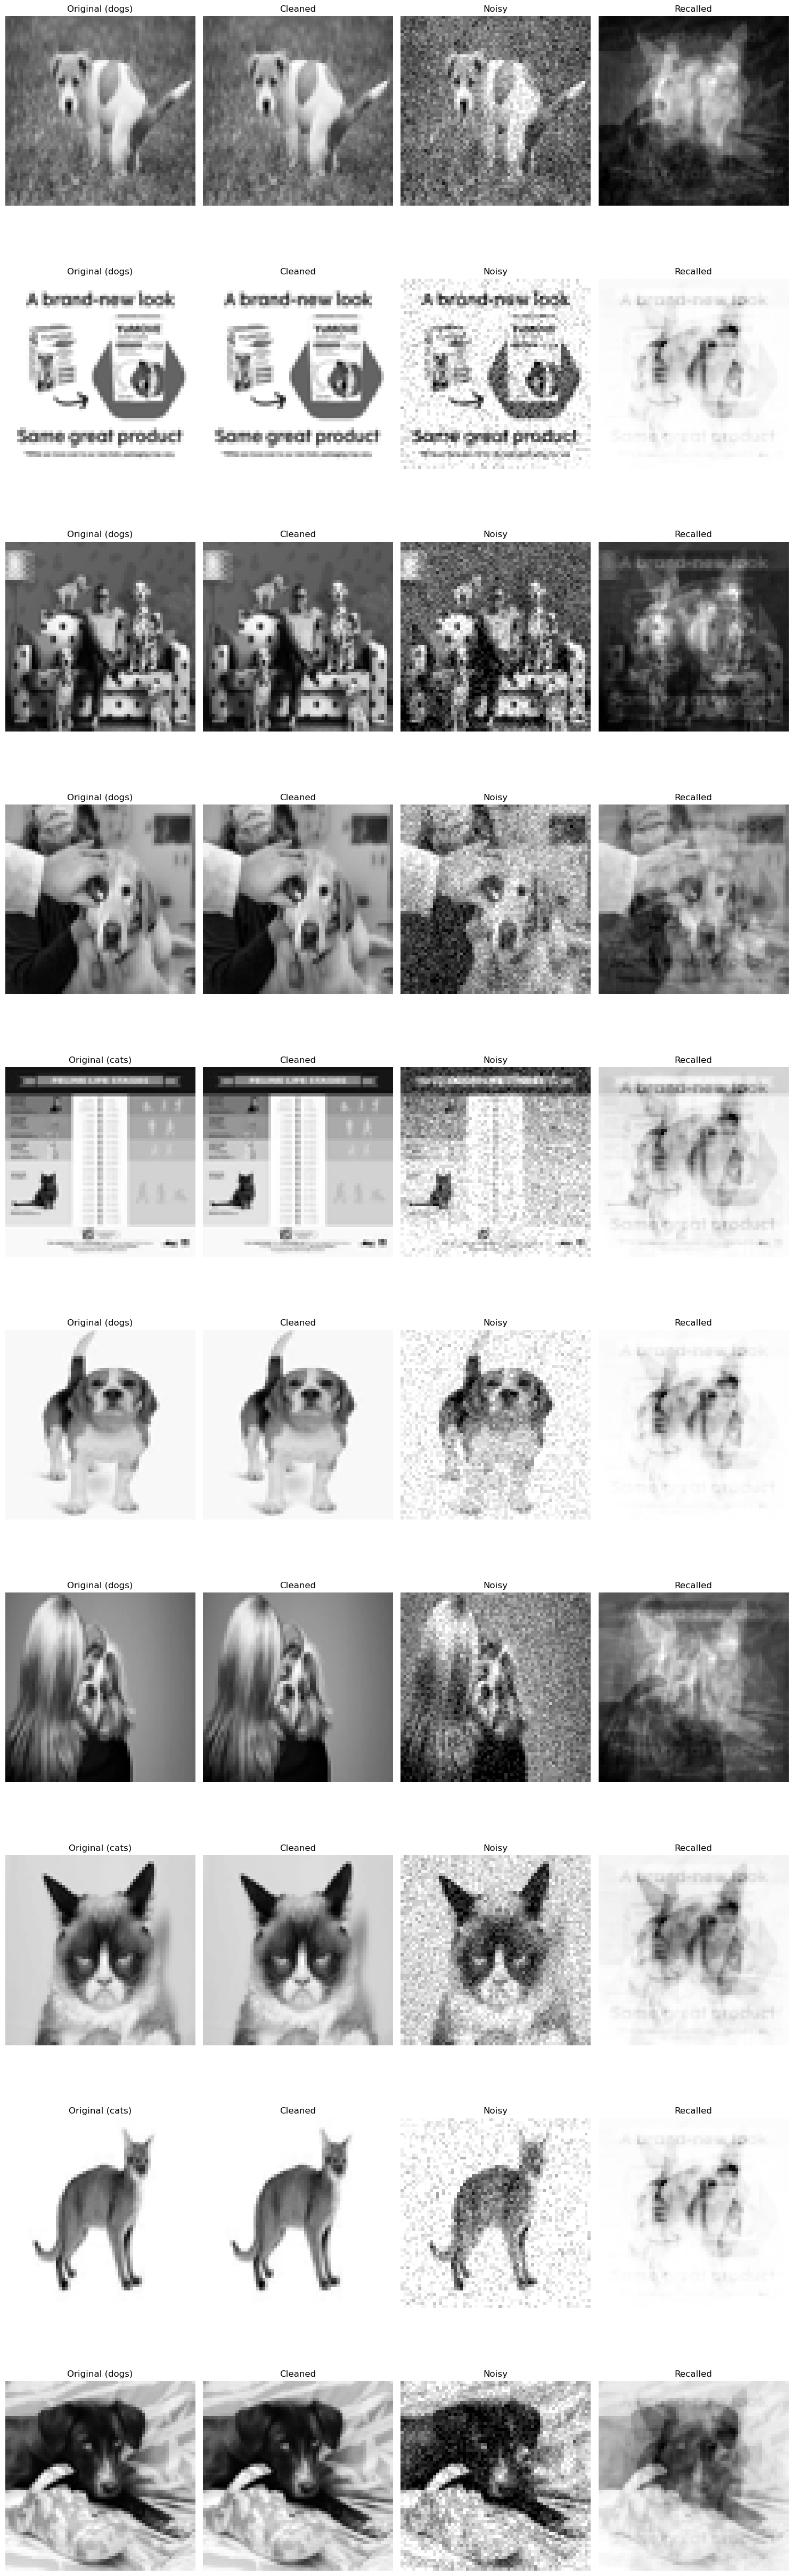

Classification accuracy with 10 training images (binary: False, rule: hebbian,neuons:(64, 64)): 0.50


In [9]:
# Base model with more neurons
train_counts = [10]
results_more_neurons_non_binary, confs_more_neurons_non_binary = run_hopfield_experiment(
    learning_rule="hebbian",
    hebbian_trainer=hebbian_trainer,
    train_counts= train_counts,
    storkey_rule=storkey_rule,
    imageGenerator=imageGenerator,
    prediction=prediction,
    plot_image_reconstruction=plot_image_reconstruction,
    image_size=(64, 64), # More neurons
    binary = False
)

np.savez("results_more_nodes_non_binary.npz", results=results_more_neurons_non_binary, confs=confs_more_neurons_non_binary)

## Plotting learning improvement


In [ ]:
color_hebbian = "#9b5de5"      # violet-purple
color_more_neurons = "#f15bb5" # hot pink
color_non_binary = "#00bbf9"   # cyan

# --- Create figure with subplots ---
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()  # make it easy to index as a 1D array

# --- Plot 1: Base model ---
axes[0].plot(train_counts, results_hebbian, 'o-', color=color_hebbian)
axes[0].set_title("Base Hebbian model")
axes[0].set_xlabel("Training images")
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim(0, 1)
axes[0].grid(True)

# --- Plot 2: More neurons model ---
axes[1].plot(train_counts, results_more_neurons, 's-', color=color_more_neurons)
axes[1].set_title("More neurons model")
axes[1].set_xlabel("Training images")
axes[1].set_ylabel("Accuracy")
axes[1].set_ylim(0, 1)
axes[1].grid(True)

# --- Plot 3: Non-binary model ---
axes[2].plot(train_counts, results_non_binary, '^-', color=color_non_binary)
axes[2].set_title("Non-binary model")
axes[2].set_xlabel("Training images")
axes[2].set_ylabel("Accuracy")
axes[2].set_ylim(0, 1)
axes[2].grid(True)

# --- Plot 4: Combined comparison ---
axes[3].plot(train_counts, results_hebbian, 'o-', color=color_hebbian, label='Base model')
axes[3].plot(train_counts, results_more_neurons, 's-', color=color_more_neurons, label='More neurons')
axes[3].plot(train_counts, results_non_binary, '^-',  color=color_non_binary, label='Non-binary')
axes[3].set_title("All models compared")
axes[3].set_xlabel("Training images")
axes[3].set_ylabel("Accuracy")
axes[3].set_ylim(0, 1)
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()


## Plotting all the confusion matrices together

In [ ]:
models = {
    "Base Hebbian": {
        "results": results_hebbian,
        "confs": confs_hebbian,
        "color": "Purples"
    },
    "More neurons": {
        "results": results_more_neurons,
        "confs": confs_more_neurons,
        "color": plt.cm.RdPu
    },
    "Non-binary": {
        "results": results_non_binary,
        "confs": confs_non_binary,
        "color": "Blues"
    }
}

# Plotting the confusion matrices
for model_name, model_data in models.items():
    conf_matrices = model_data["confs"]
    color = model_data["color"]

    num_plots = len(conf_matrices)
    cols = 3
    rows = int(np.ceil(num_plots / cols))

    plt.figure(figsize=(5 * cols, 5 * rows))

    for i, (cm, n_train) in enumerate(zip(conf_matrices, train_counts)):
        ax = plt.subplot(rows, cols, i + 1)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['dog', 'cat'])
        disp.plot(cmap=color, values_format='d', ax=ax, colorbar=False)
        ax.set_title(f"{n_train} training images")

    plt.suptitle(f"{model_name}: Confusion Matrices Across Training Levels", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

### Original Code 
#### From: https://github.com/nosratullah/hopfieldNeuralNetwork?tab=readme-ov-file

In [ ]:
"""
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc as sp
import matplotlib.image as img

# import the image and extract
def imageGenerator(imageVector):
    cleanImage = np.zeros([len(imageVector)-1,len(imageVector)-1])
    for i in range(len(imageVector)-1):
        for j in range(len(imageVector)-1):
            if (imageVector[i][j] > 1):
                cleanImage[i][j] = 1
            else:
                cleanImage[i][j] = -1
    noisyImage = cleanImage + np.random.normal(0, 2, [len(image)-1,len(image)-1])

    for i in range(len(image)-1):
        for j in range(len(image)-1):
            if (noisyImage[i][j] >= 0):
                noisyImage[i][j] = 1
            else:
                noisyImage[i][j] = -1

    return cleanImage,noisyImage
# Building up the coefficient matrix
def trainer(vector,oldCoefMat):
    vector = vector.flatten()
    coefMat = np.zeros([len(vector)-1,len(vector)-1])
    if (np.isscalar(oldCoefMat)):
        for i in range(len(vector)-1):
            for j in range(len(vector)-1):
                if (i!=(i-j)):
                    coefMat[i][i-j] = vector[i]*vector[i-j]
    if (np.shape(oldCoefMat) == np.shape(coefMat)):
        for i in range(len(vector)-1):
            for j in range(len(vector)-1):
                if (i!=(i-j)):
                    coefMat[i][i-j] = vector[i]*vector[i-j]
        coefMat = coefMat + oldCoefMat

    vector = np.reshape(vector, [int(np.sqrt(len(vector))),int(np.sqrt(len(vector)))])
    return coefMat

#
def prediction(curuptedVec,coefMat):
    curuptedVec = curuptedVec.flatten()
    predictVec = np.zeros(len(curuptedVec))
    for i in range(len(curuptedVec)-1):
        temp = 0
        for j in range(len(curuptedVec)-1):
             temp += coefMat[i][j] * curuptedVec[j]
        if (temp>0):
            predictVec[i] = 1
        if (temp<0):
            predictVec[i] = -1

    predictVec = np.reshape(predictVec, [int(np.sqrt(len(predictVec))),int(np.sqrt(len(predictVec)))])
    return predictVec


#Import the images
plt.figure(figsize=(15,10))
for i in range(1,4):
    image = img.imread('dataset/pgms/{}.png'.format(i),'w').copy()
    if (i==1):
        vector,noisyVec = imageGenerator(image)
        coefMatrix = trainer(vector,0)
        predictedVec = prediction(noisyVec,coefMatrix)
    else:
        vector,noisyVec = imageGenerator(image)
        coefMatrix = trainer(vector,coefMatrix)
        predictedVec = prediction(noisyVec,coefMatrix)

    plt.subplot(i,4,1)
    plt.imshow(image)
    plt.title('Imported Picture 1')
    plt.subplot(i,4,2)
    plt.imshow(vector);
    plt.title('Cleaned and Squared Picture 1')
    plt.subplot(i,4,3)
    plt.imshow(noisyVec);
    plt.title('Noisy Picture 1')
    plt.subplot(i,4,4)
    plt.imshow(predictedVec);
    plt.title('Recalled Picture 1')

plt.savefig('hopfields.png')
plt.clf()
plt.imshow(coefMatrix)
plt.savefig('matrix.png')
plt.title('Coefficient Matrix')
plt.show()
"""